**Sarcasm Detection Case Study**
Loading sarcasm detection dataset from this source - it is high quality data from The Onion which is a sarcastic news site. Idea is to use this to test pretrained models from Hugging Face for sarcasm detection and compare. We use a bidirectional LSTM architecture with GLOVE embeddings (which achieved 95% on the laptop reviews dataset before) to train on the whole dataset and evaluate on the test set.
# https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

url = 'https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json'


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Flatten, GlobalMaxPooling1D, Conv1D, LSTM,Embedding, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

In [ ]:
import requests
import json

# Replace the URL below with the raw URL of your JSON file
url = 'https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json'

# Fetch the file from the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Split the response text by newlines
    lines = response.text.splitlines()

    # Parse each line as a JSON object and append to a list
    data = [json.loads(line) for line in lines]

    # Create a DataFrame from the list
    df = pd.DataFrame(data)

    # Display the first few rows of the DataFrame
    print(df.head())
else:
    print(f"Failed to retrieve the file: {response.status_code}")


   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  


In [ ]:
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [ ]:
# prompt: df1 is_sarcastic and headline from df

df1 = df[['is_sarcastic', 'headline']]


In [ ]:
# prompt: import train test split and use 20% data for test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.headline, df1.is_sarcastic, test_size=0.10,random_state=42)


In [ ]:
y_test.shape

(2862,)

In [ ]:
y_test.value_counts()

0    1506
1    1356
Name: is_sarcastic, dtype: int64

Bidirectional LSTM with GLOVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train1 = word_tokenizer.texts_to_sequences(X_train)
X_test1 = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding all reviews to fixed length 100, truncate

maxlen = 100

X_train2 = pad_sequences(X_train1, padding='post', maxlen=maxlen) # pre or post
X_test2 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

vocab_length = len(word_tokenizer.word_index)+1
vocab_length

29395

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/mtech/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector # 92394 rows, 100 columns of embed numberical values

In [ ]:
from keras.layers import Bidirectional
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_bidirectional_model = Sequential()
lstm_bidirectional_model.add(embedding_layer)  # Assuming embedding_layer is already defined as in your code
lstm_bidirectional_model.add(Bidirectional(LSTM(128)))
# lstm_bidirectional_model.add(Dense(64,activation='relu'))
lstm_bidirectional_model.add(Dense(1, activation='sigmoid'))


In [ ]:
# Model compiling

lstm_bidirectional_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_bidirectional_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          8818500   
                                                                 
 bidirectional (Bidirection  (None, 512)               1140736   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 9959749 (37.99 MB)
Trainable params: 1141249 (4.35 MB)
Non-trainable params: 8818500 (33.64 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_bidirectional_model_history = lstm_bidirectional_model.fit(X_train2, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
161/161 [==============================] - 24s 111ms/step - loss: 0.4678 - acc: 0.7769 - val_loss: 0.3908 - val_acc: 0.8257
Epoch 2/6
161/161 [==============================] - 18s 110ms/step - loss: 0.3441 - acc: 0.8492 - val_loss: 0.3511 - val_acc: 0.8377
Epoch 3/6
161/161 [==============================] - 19s 117ms/step - loss: 0.4989 - acc: 0.7608 - val_loss: 0.4242 - val_acc: 0.8076
Epoch 4/6
161/161 [==============================] - 19s 117ms/step - loss: 0.3788 - acc: 0.8295 - val_loss: 0.3665 - val_acc: 0.8360
Epoch 5/6
161/161 [==============================] - 18s 109ms/step - loss: 0.3122 - acc: 0.8655 - val_loss: 0.3269 - val_acc: 0.8556
Epoch 6/6
161/161 [==============================] - 19s 116ms/step - loss: 0.2688 - acc: 0.8873 - val_loss: 0.3078 - val_acc: 0.8663


In [ ]:
score = lstm_bidirectional_model.evaluate(X_test2, y_test, verbose=1)

90/90 [==============================] - 2s 18ms/step - loss: 0.3114 - acc: 0.8658


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.31135764718055725
Test Accuracy: 0.8658280968666077


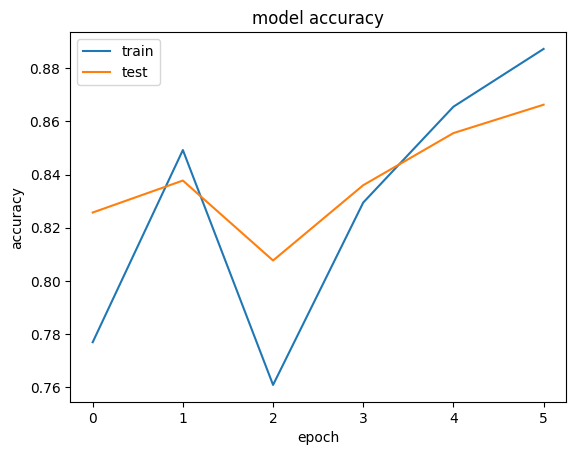

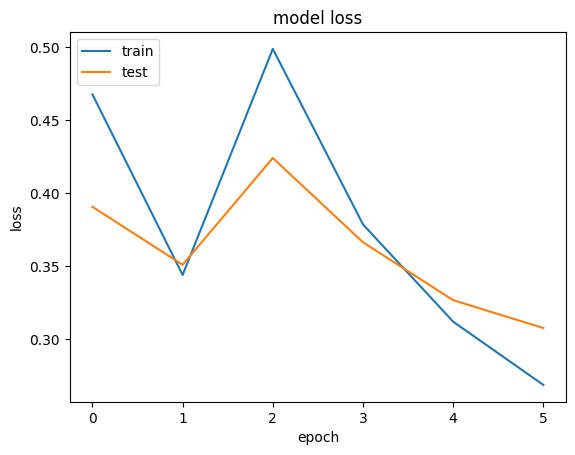

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_bidirectional_model_history.history['acc'])
plt.plot(lstm_bidirectional_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_bidirectional_model_history.history['loss'])
plt.plot(lstm_bidirectional_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
X_test2

array([[  471,  2414,     1, ...,     0,     0,     0],
       [ 1687,  1488,  3415, ...,     0,     0,     0],
       [   39,   616,     2, ...,     0,     0,     0],
       ...,
       [  262,   245,   167, ...,     0,     0,     0],
       [12408,  2377,  5097, ...,     0,     0,     0],
       [ 6653,   322, 12191, ...,     0,     0,     0]], dtype=int32)

In [ ]:
t1 = ["Prequel Depicts Young Willy Wonka Using Rich Father’s Investment To Buy Already-Successful Chocolate Factory"]
t10 = word_tokenizer.texts_to_sequences(t1)

t11 = pad_sequences(t10, padding='post', maxlen=maxlen)
lstm_bidirectional_model.predict(t11)

1/1 [==============================] - 1s 941ms/step


array([[0.63421035]], dtype=float32)

In [ ]:
t2 = ["India women create history with 410 runs on day 1 of only Test against England"]
t20 = word_tokenizer.texts_to_sequences(t2)

t21 = pad_sequences(t20, padding='post', maxlen=maxlen)
lstm_bidirectional_model.predict(t21)

1/1 [==============================] - 0s 33ms/step


array([[0.4622216]], dtype=float32)

In [ ]:
t3 = ["Oh great, here comes another Monday"]
t30 = word_tokenizer.texts_to_sequences(t3)

t31 = pad_sequences(t30, padding='post', maxlen=maxlen)
lstm_bidirectional_model.predict(t31)

1/1 [==============================] - 0s 35ms/step


array([[0.14586952]], dtype=float32)